author: Manuel H. Arias

Twitter: @walyt

Github: @mharias

mail: mharias@me.com

# Visualización de datos de la pandemia de SARS-CoV-2

En esta entrada vamos a mostrar el código para descargar los datos sobre la evolución del Sars-Covid-2, del repositorio de open data http://data.world, en esta [url](https://data.world/covid-19-data-resource-hub/covid-19-case-counts/workspace/file?filename=COVID-19+Cases.csv) puedes ver la homepage del proyecto. En la documentación del mismo se indica que los datos se descargan diariamanete de este [github](https://github.com/CSSEGISandData/COVID-19) de la [Johns Hopkins](https://github.com/CSSEGISandData).
Es versión 2 con un path actualizado desde 5 Junio, ha habido que cambiar ciertos nombres de columnas.
Update : 26 Julio:han cambiado el orden de las columnas

Importamos las librerías estándares para ejercicios de visualización de datos.

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange)
import numpy as np
from datetime import datetime
import seaborn as sns
%matplotlib inline

Actualizamos el número máximo de filas que podemos ver al mostrar un objeto $pandas$

In [29]:
pd.options.display.max_rows = 999

Descargamos, desde su url, los datos de interés:

In [30]:
path_datos = 'https://query.data.world/s/h4czc4bz7zdzhsm4tgzkistgaxhyfr'
path_github = ' https://github.com/mharias/covid/blob/master/stats_cvid_paises_v2.ipynb'

In [ ]:
df = pd.read_csv(path_datos)

veamos una rápida descripción de la información:

In [ ]:
df.describe()

In [ ]:
df.tail()

In [ ]:
df[df['COUNTRY_SHORT_NAME']=='Spain']['REPORT_DATE'].sort_values().unique()[-1]

En la [url](https://data.world/covid-19-data-resource-hub/covid-19-case-counts/workspace/file?filename=COVID-19+Cases.csv) del proyecto vemos la descripción de cada uno de los campos.

Vamos a formatear correctamente la columna $Date$, para posteriormente ordenar el $pandas$ por fecha creciente:

In [ ]:
df['REPORT_DATE']=pd.to_datetime(df['REPORT_DATE'])

In [ ]:
lista_paises = set(df['COUNTRY_SHORT_NAME'])

In [ ]:
df.columns

In [ ]:
list_columnas=df.columns

In [ ]:
for i,columna in enumerate(list_columnas):
    print ('Columna número {}: {}'.format(i,columna))

In [ ]:
clave_pais = 'COUNTRY_SHORT_NAME'

In [ ]:
columnas_interes=[0,3,6,9,11,12]
indice=[3,9]
valores=[0,6,11,12]

Con el objetivo de centrarnos en una lista de países de interés, vamos a crear una variable $lista$ que los contenga. Obviamente puedes libremente actualizar esa lista, siempre asegurándose de que la el país está corerctamente escrito y está incluído en :

In [ ]:
paises_interes=['China','Spain','United States','India','Italy','Russia','Mexico','Germany','France','United Kingdom','Brazil','Netherlands']

In [ ]:
paises_interes_2=['Sweden','Denmark','Norway','India','Italy','Portugal','Finland','Germany','France','United Kingdom','Brazil','Netherlands']

In [ ]:
paises_interes=['Austria','Belgium','France','Germany','Italy','Luxembourg','Netherlands','Portugal','Spain','Sweden','Switzerland','United Kingdom']

In [ ]:
paises_interes=['Argentina','Austria','Belgium','Brazil','China','France','Germany','India',
                'Ireland','Israel','Italy','Mexico','Netherlands','Portugal',
                'Peru','Russia','Spain','Sweden','Switzerland',
                'United Kingdom','United States']

In [ ]:
poblacion={'Israel':8810,'Belgium':11533,'France':64926,'Germany':83243,'Italy':60294,'Luxembourg':602.5,'Netherlands':17431,
           'Portugal':10264,'Russia':146712,'Spain':47441,'Sweden':10364,'Switzerland':8647,'United Kingdom':67180,
           'China':1403426,'United States':331800,'India':1409902,'Mexico':127792,'Brazil':211420,
           'Argentina':45377,'Peru':32824,'Pakistan':224654,'Israel':9229,'Austria':8926,'Ireland':4904}

Filtramos el $pandas$ original quedándonos con 4 columnas de con los datos que nos interesan, creando un $df2$ con los países de interés incluídos en la lista. Indexamos el $pandas$ con un multiindex ['Date','Country_Region']:

In [ ]:
grouper={}
for i in valores:
    grouper[list_columnas[i]]=np.sum

In [ ]:
df2=df[list_columnas[columnas_interes]].pivot_table(index=list(list_columnas[indice]),
                                                    values=list(list_columnas[valores]),
                                                    aggfunc=grouper).sort_values(['REPORT_DATE'])

In [ ]:
df2.columns=['DEATHS','DEATHS_INC','CONFIRMED','CONFIRMED_INC']

In [ ]:
df2.head()

Añadimos una columna con el ratio Fallecimientos vs Casos Confirmados (Death to Confirmed):

In [ ]:
df2['D2C']=df2['DEATHS']/df2['CONFIRMED']

Y con el objetivo de facilitar la creación de gráficos vamos a crear un diccionario, con los países como clave, que y que nos devuelva un `pandas` por cada país. A ese `pandas`
 le hemos añadido unas columnas adicionales:

1. `Inc_Confirmed` : Confirmados diarios incrementales, que calculamos por medio de la función `diff()`.

2. `Inc_Deaths` : Fallecimiento diarios, que calculamos de igual manera con la función `diff()`.
3. `Ratio_Confirmed`: Equivalente al ratio entre los `Inc_Confirmed` y los `Confirmed`
4. Y finalmente `inc`: equivalente a la variación diaria en porcentual de `Inc_Confirmed`,  

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
resultados={}
for pais in paises_interes:
    df_aux=df2.xs(pais,level=1,drop_level=True)
    df_aux['Ratio_Confirmed']=df_aux['CONFIRMED_INC']/df_aux['CONFIRMED']
    df_aux['inc']=df_aux['CONFIRMED_INC'].pct_change()
    resultados[pais]=df_aux
pd.options.mode.chained_assignment = 'warn'

In [ ]:
resultados['Spain']['CONFIRMED_INC'].plot()

## Empezamos con lo gráficos:
### Casos confirmados, fallecimiento y su ratio en la lista de países de interés

In [ ]:
def format_y(value, tick_number):
    return '{:.1%}'.format(value)

In [ ]:
def format_func(value, tick_number):
        #función para formateo de la etiqueta de los valores Date en el eje x
        # devuelve un formato tal que : dia-mes
        return  datetime.fromordinal(int(value)).strftime('%d-%b')

In [ ]:
f = plt.figure(figsize=(15,12))
f.subplots_adjust(hspace=.5, wspace=.5)
f.suptitle('Acumulated Confirmed and Deaths figures per country: '+datetime.today().strftime('%d/%m/%Y')
           ,fontsize=30,y=0)
ax1 = f.add_subplot(341)
ax2 = f.add_subplot(342)
ax3 = f.add_subplot(343)
ax4 = f.add_subplot(344)
ax5 = f.add_subplot(345)
ax6 = f.add_subplot(346)
ax7= f.add_subplot(347)
ax8= f.add_subplot(348)
ax9= f.add_subplot(349)
ax10= f.add_subplot(3,4,10)
ax11= f.add_subplot(3,4,11)
ax12 = f.add_subplot (3,4,12)
#f.subplots_adjust(hspace=.5, wspace=0.5)
lista_axes=f.get_axes()
#sns.set(palette='deep')
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("RdBu_r",7))
#sns.color_palette("husl")
#sns.palplot("BrBG")
for i in range(12):                                     
    t=resultados[paises_interes[i]].index
    data1=resultados[paises_interes[i]]['D2C']
    data2=resultados[paises_interes[i]]['CONFIRMED']
    data3=resultados[paises_interes[i]]['DEATHS']
    lista_axes[i].set_title(paises_interes[i],size=20)
    sns.lineplot(t, data1, ax=lista_axes[i],color=sns.color_palette('RdBu_r',7)[6],linewidth=3)
    lista_axes[i].tick_params(axis='y', labelsize=10,labelcolor=sns.color_palette('RdBu_r',7)[6])
    if i % 4 == 0 :
        lista_axes[i].set_ylabel('Ratio Death vs Confirmed', size=15,color=sns.color_palette('RdBu_r',7)[6])
    else:
        lista_axes[i].set_ylabel('', color='blue',size=15)
        
    lista_axes[i].get_xaxis().set_ticks([])
    lista_axes[i].get_xaxis().set_visible(False)
    lista_axes[i].yaxis.set_major_formatter(plt.FuncFormatter(format_y))
    sns.despine(f)

    ax2 = lista_axes[i].twinx()  # instantiate a second axes that shares the same x-axis
    
    ax2.grid(False)
    #ax2.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    
    sns.lineplot(t, data2, label='Confirmed',ax=ax2,color=sns.color_palette('RdBu_r',7)[0],linewidth=3)
    sns.lineplot(t,data3,label='Deaths',ax=ax2,color=sns.color_palette('RdBu_r',7)[2],linewidth=3)
    
    
    ax2.set_ylabel('', color=sns.color_palette('RdBu_r',7)[0])
    ax2.set_xlabel('')
    ax2.get_xaxis().set_visible(True)   
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax2.tick_params(axis='y',labelsize=10,labelcolor=sns.color_palette('RdBu_r',7)[0])
    ax2.tick_params(axis='x',labelrotation=90)
    ax2.legend()
    #ax2.set_yscale('log')
    
    #f.tight_layout()  # otherwise the right y-label is slightly clipped
f.savefig('graficos/grafico1.png')

### Casos confirmados diarios, junto con su porcentaje frente al total acumulado de confirmados.

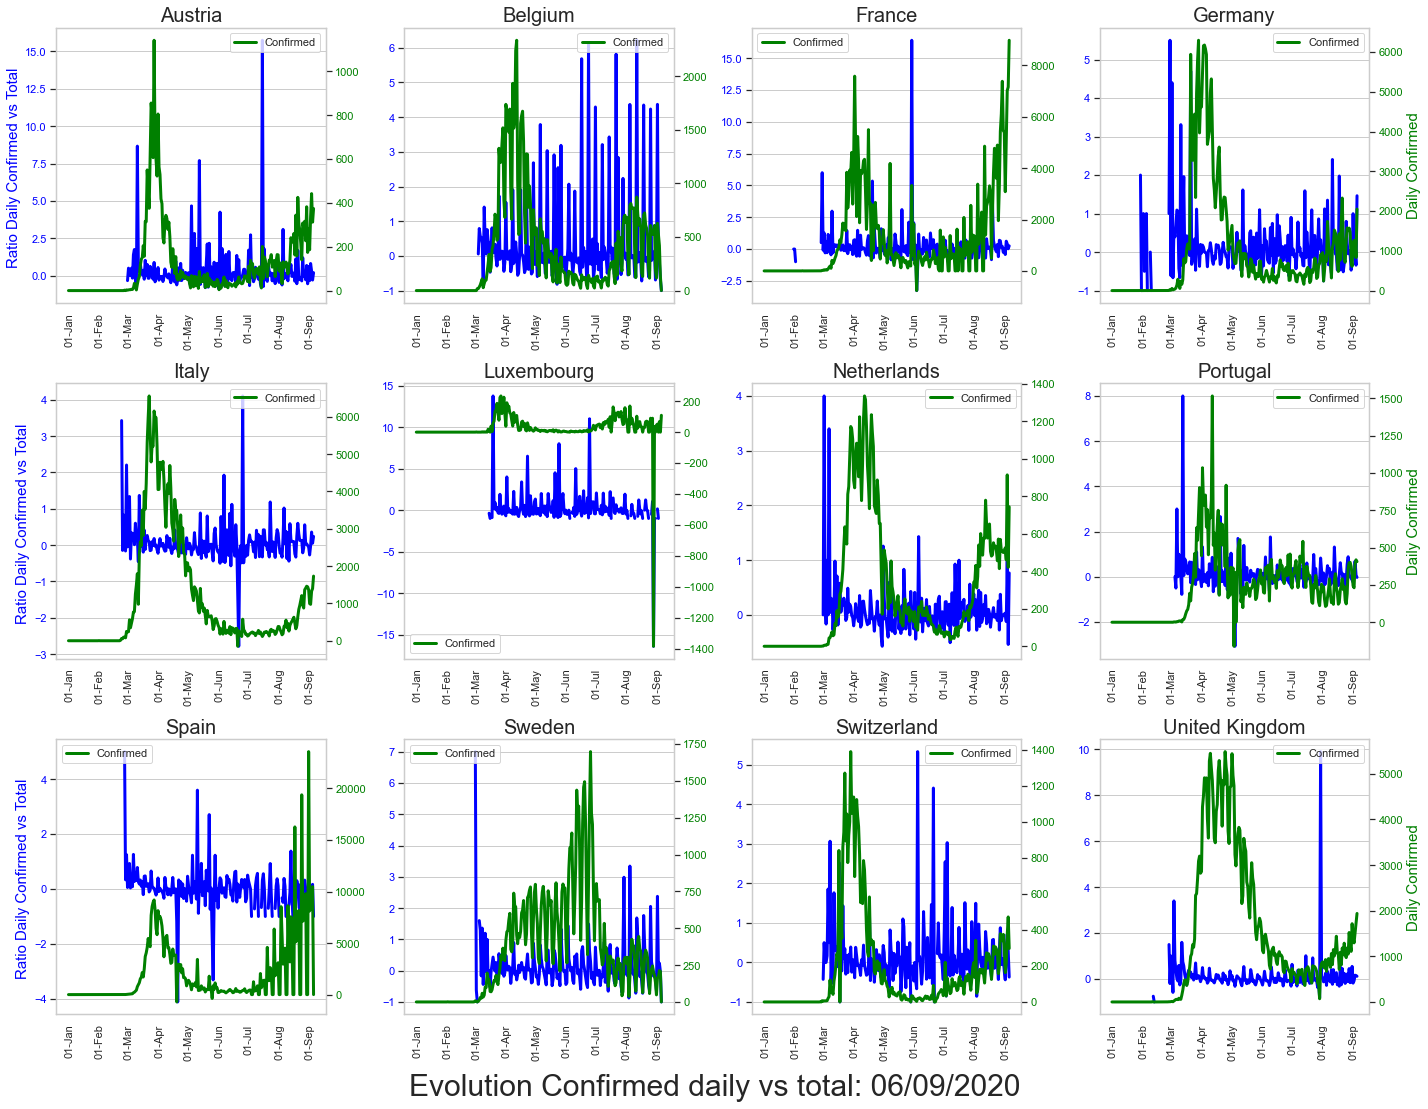

In [57]:
f = plt.figure(figsize=(20,15))
f.subplots_adjust(hspace=.5, wspace=.5)
f.suptitle('Evolution Confirmed daily vs total: '+datetime.today().strftime('%d/%m/%Y')
           ,fontsize=30,y=0)
ax1 = f.add_subplot(341)
ax2 = f.add_subplot(342)
ax3 = f.add_subplot(343)
ax4 = f.add_subplot(344)
ax5 = f.add_subplot(345)
ax6 = f.add_subplot(346)
ax7= f.add_subplot(347)
ax8= f.add_subplot(348)
ax9= f.add_subplot(349)
ax10= f.add_subplot(3,4,10)
ax11= f.add_subplot(3,4,11)
ax12 = f.add_subplot (3,4,12)
lista_axes=f.get_axes()
sns.set_style("whitegrid")
for i in range(12):
    t=resultados[paises_interes[i]].index
    data1=resultados[paises_interes[i]]['inc']
    
    data2=resultados[paises_interes[i]]['CONFIRMED_INC']
    lista_axes[i].set_title(paises_interes[i],size=20)
    sns.lineplot(t, data1, ax=lista_axes[i],color='blue',linewidth=3)
    lista_axes[i].tick_params(axis='y', labelcolor='blue')
    if i % 4 == 0 :
        lista_axes[i].set_ylabel('Ratio Daily Confirmed vs Total ', color='blue',size=15)
    else:
        lista_axes[i].set_ylabel('', color='blue',size=15)
    
    lista_axes[i].get_xaxis().set_ticks([])
    lista_axes[i].get_xaxis().set_visible(False)

    ax2 = lista_axes[i].twinx()  # instantiate a second axes that shares the same x-axis
    
    ax2.grid(False)
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    sns.lineplot(t, data2, label='Confirmed',ax=ax2,color='green',linewidth=3)
    
    if i % 4 == 3:
        ax2.set_ylabel('Daily Confirmed', color='green',size=15)
    else:
        ax2.set_ylabel('', color='green',size=15)
    ax2.get_xaxis().set_visible(True)   
    ax2.set_xlabel('')
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.tick_params(axis='x',labelrotation=90)
    ax2.legend()
    ax2.set_yscale('linear')
    f.tight_layout()  # otherwise the right y-label is slightly clipped
f.savefig('graficos/inc_confirmed.png')

### Vamos a generar curvas cuyo `t=0` depende de un determinado threshold: fallecimientos o confirmados equivalentes a un determinado nivel..

Definimos un par de funciones auxiliares que de un `pandas`de entrada, y un determinado threshold, nos devuelve el `pandas`debidamente filtrado:

In [58]:
def deaths_threshold(res_pandas,threshold):
    dia_zero=res_pandas[res_pandas['DEATHS']>threshold].index[0]
    return res_pandas[res_pandas.index>=dia_zero]

def confirmed_threshold(res_pandas,threshold):
    dia_zero=res_pandas[res_pandas['CONFIRMED']>threshold].index[0]
    return res_pandas[res_pandas.index>=dia_zero]

Definimos ahora una función que convierte el eje X que tiene Date, a números ordinales. Esto es necesario puesto que cada país tiene una fecha 'threshold' diferente con lo que no se puede utilizar un eje X de fechas.

In [59]:
def re_index(res_pandas):
    aux={}
    for i in res_pandas:
        new_index=np.arange(len(res_pandas[i]))
        aux[i]=res_pandas[i].rename(index=dict(zip(res_pandas[i].index,new_index)))
    return aux

Y como nos pueden interesar diferentes tipos de gráficos en función de la categoría a presentar y los threshold a usar, definiremos entonces una función a la que se le pueden pasar como argumentos esos valores. He añadido adicionalmente la posibilidad de eliminar China:

In [60]:
def grafico_threshold (datos,category_threshold,threshold,China=True,scale='linear'):
    res_aux={}
    color_pais={}
    current_palette = sns.color_palette('Paired')
    
    for i,pais in enumerate(datos):
        color_pais[pais]=current_palette[i]
        if category_threshold=='CONFIRMED':
            res_aux[pais]=confirmed_threshold(datos[pais],threshold)
        else:
            res_aux[pais]=deaths_threshold(datos[pais],threshold)
    if not China:
    # por si acaso datos no incluye de antemano el valor China    
        try: 
            del res_aux['China']
        except:
            pass
        
    res_aux=re_index(res_aux)
    f = plt.figure(figsize=(10,5))
    ax1 = f.add_subplot(111)
    ax1.set_title('Acumulated '+category_threshold+' from threshold = '+str(threshold),size=20)
    #f.subplots_adjust(hspace=.5, wspace=0.5)
    #sns.set(palette='deep')
    sns.set_style("whitegrid")
    #current_palette = sns.color_palette('husl',12)
    
    sns.set_palette(current_palette)
    for i in res_aux:
        t=res_aux[i].index
        sns.lineplot(t, res_aux[i][category_threshold], label=i,ax=ax1,linewidth=4,color=color_pais[i])
        ax1.get_xaxis().set_visible(True)   
    ax1.set_xlabel('Days after threshold in every country', color='black',size=20)
    ax1.set_ylabel('Acumulated number of '+category_threshold, color='black',size=15)
    ax1.legend(prop={'size':10})
    ax1.set_yscale(scale)
    path="graficos/"
    nombre_fichero=path+category_threshold+'_'+str(threshold)+str('_China='+str(China))+'_'+str(scale)+'.png'
    f.savefig(nombre_fichero)
    return 
    

Veamos unos ejemplos, con Fallecimientos y Confirmados, threshold de 10 para los primeros y 100 para los segundos, e incluyendo y excluyendo China:

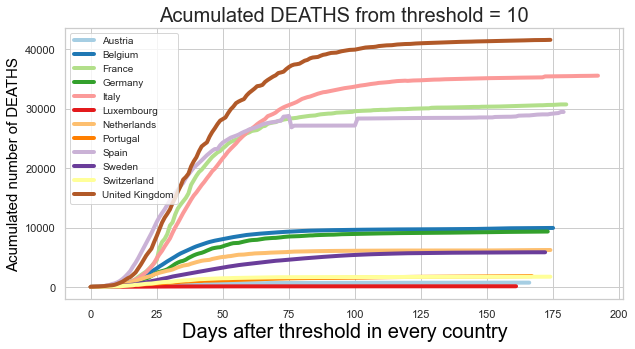

In [61]:
grafico_threshold(resultados,'DEATHS',10,China=True)

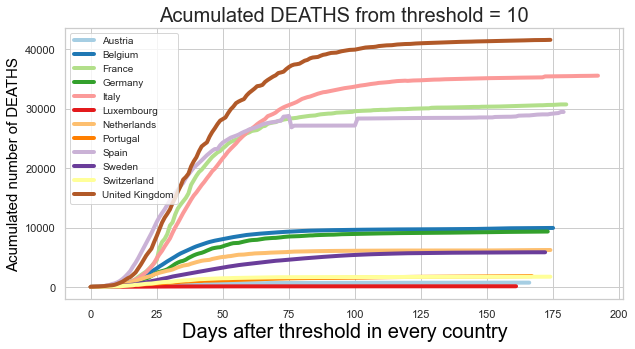

In [62]:
grafico_threshold(resultados,'DEATHS',10,China=False)

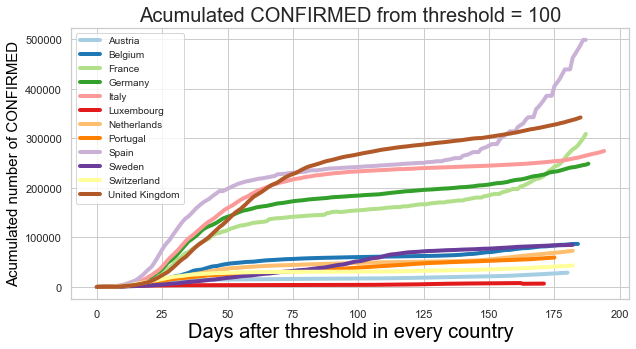

In [63]:
grafico_threshold(resultados,'CONFIRMED',100,China=True)

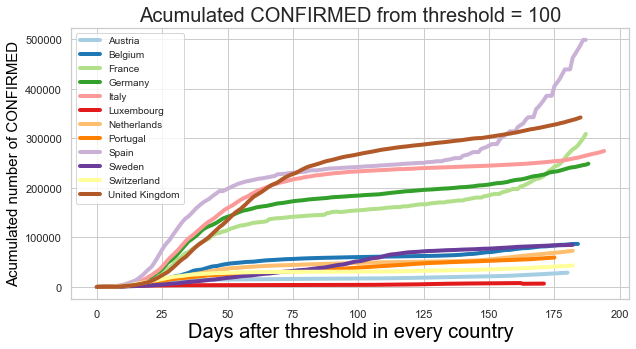

In [64]:
grafico_threshold(resultados,'CONFIRMED',100,China=False)

## Ahora generaremos curvas temporales con los valores absolutos por cada país, añadiendo la posibilidad de utilizar escala lineal (por defecto) o logarítmica en el eje `y`


In [65]:
def grafico_temporal (datos,category,China=True,scale='linear'):
    res_aux={}
    color_pais={}
    current_palette = sns.color_palette('Paired')
    res_aux=datos
    for i,pais in enumerate(datos):
        color_pais[pais]=current_palette[i]
    if not China:
        try:
            del res_aux['China']
        except:
            pass

    f = plt.figure(figsize=(10,5))
    ax1 = f.add_subplot(111)
    ax1.set_title('Acumulated '+category,size=20)
    #f.subplots_adjust(hspace=.5, wspace=0.5)
    #sns.set(palette='deep')
    sns.set_style("whitegrid")
    #current_palette = sns.color_palette('husl',12)
    
    sns.set_palette(current_palette)
    for i in res_aux:
        t=res_aux[i].index
        sns.lineplot(t, res_aux[i][category], label=i,ax=ax1,linewidth=4,color=color_pais[i])
        ax1.get_xaxis().set_visible(True)
    ax1.tick_params(axis='x',labelsize=12)
    ax1.tick_params(axis='y',labelsize=12)   
    ax1.set_xlabel('Date', color='black',size=20)
    ax1.set_ylabel('Acumulated number of '+category, color='black',size=15)
    ax1.legend(prop={'size':10})
    ax1.set_yscale(scale)
    path='graficos/'
    nombre_fichero=path+category+'_'+str('_China='+str(China))+'_'+str(scale)+'.png'
    f.savefig(nombre_fichero)
    return 

De igual manera vamos a generar varios gráficos activando cada opción..

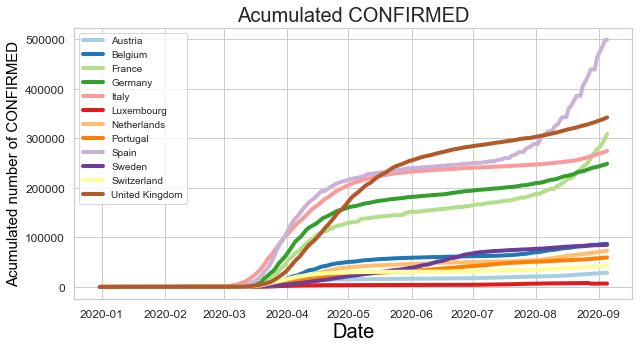

In [66]:
grafico_temporal(resultados,'CONFIRMED',China=True)

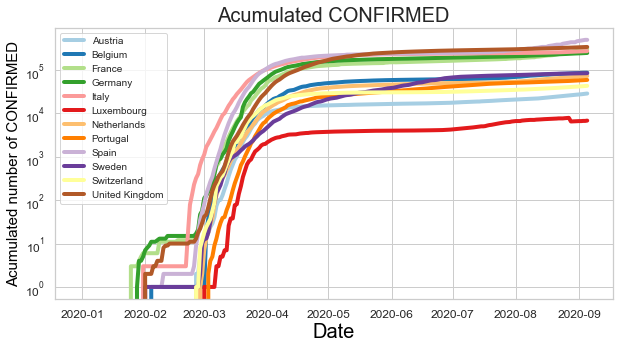

In [67]:
grafico_temporal(resultados,'CONFIRMED',China=True,scale='log')

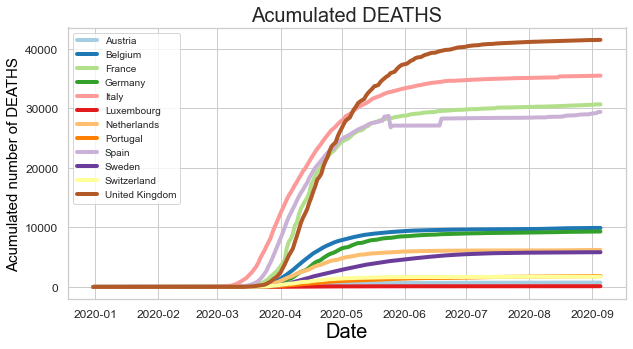

In [68]:
grafico_temporal(resultados,'DEATHS',China=True)

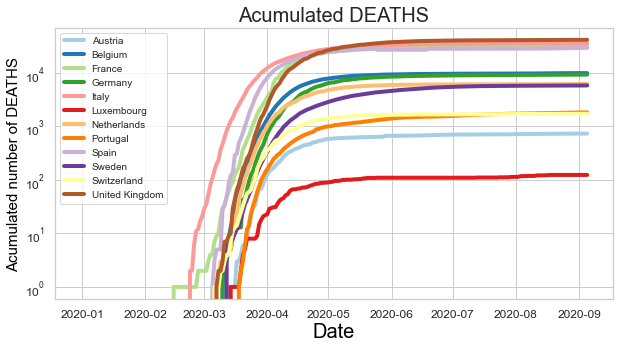

In [69]:
grafico_temporal(resultados,'DEATHS',China=True,scale='log')

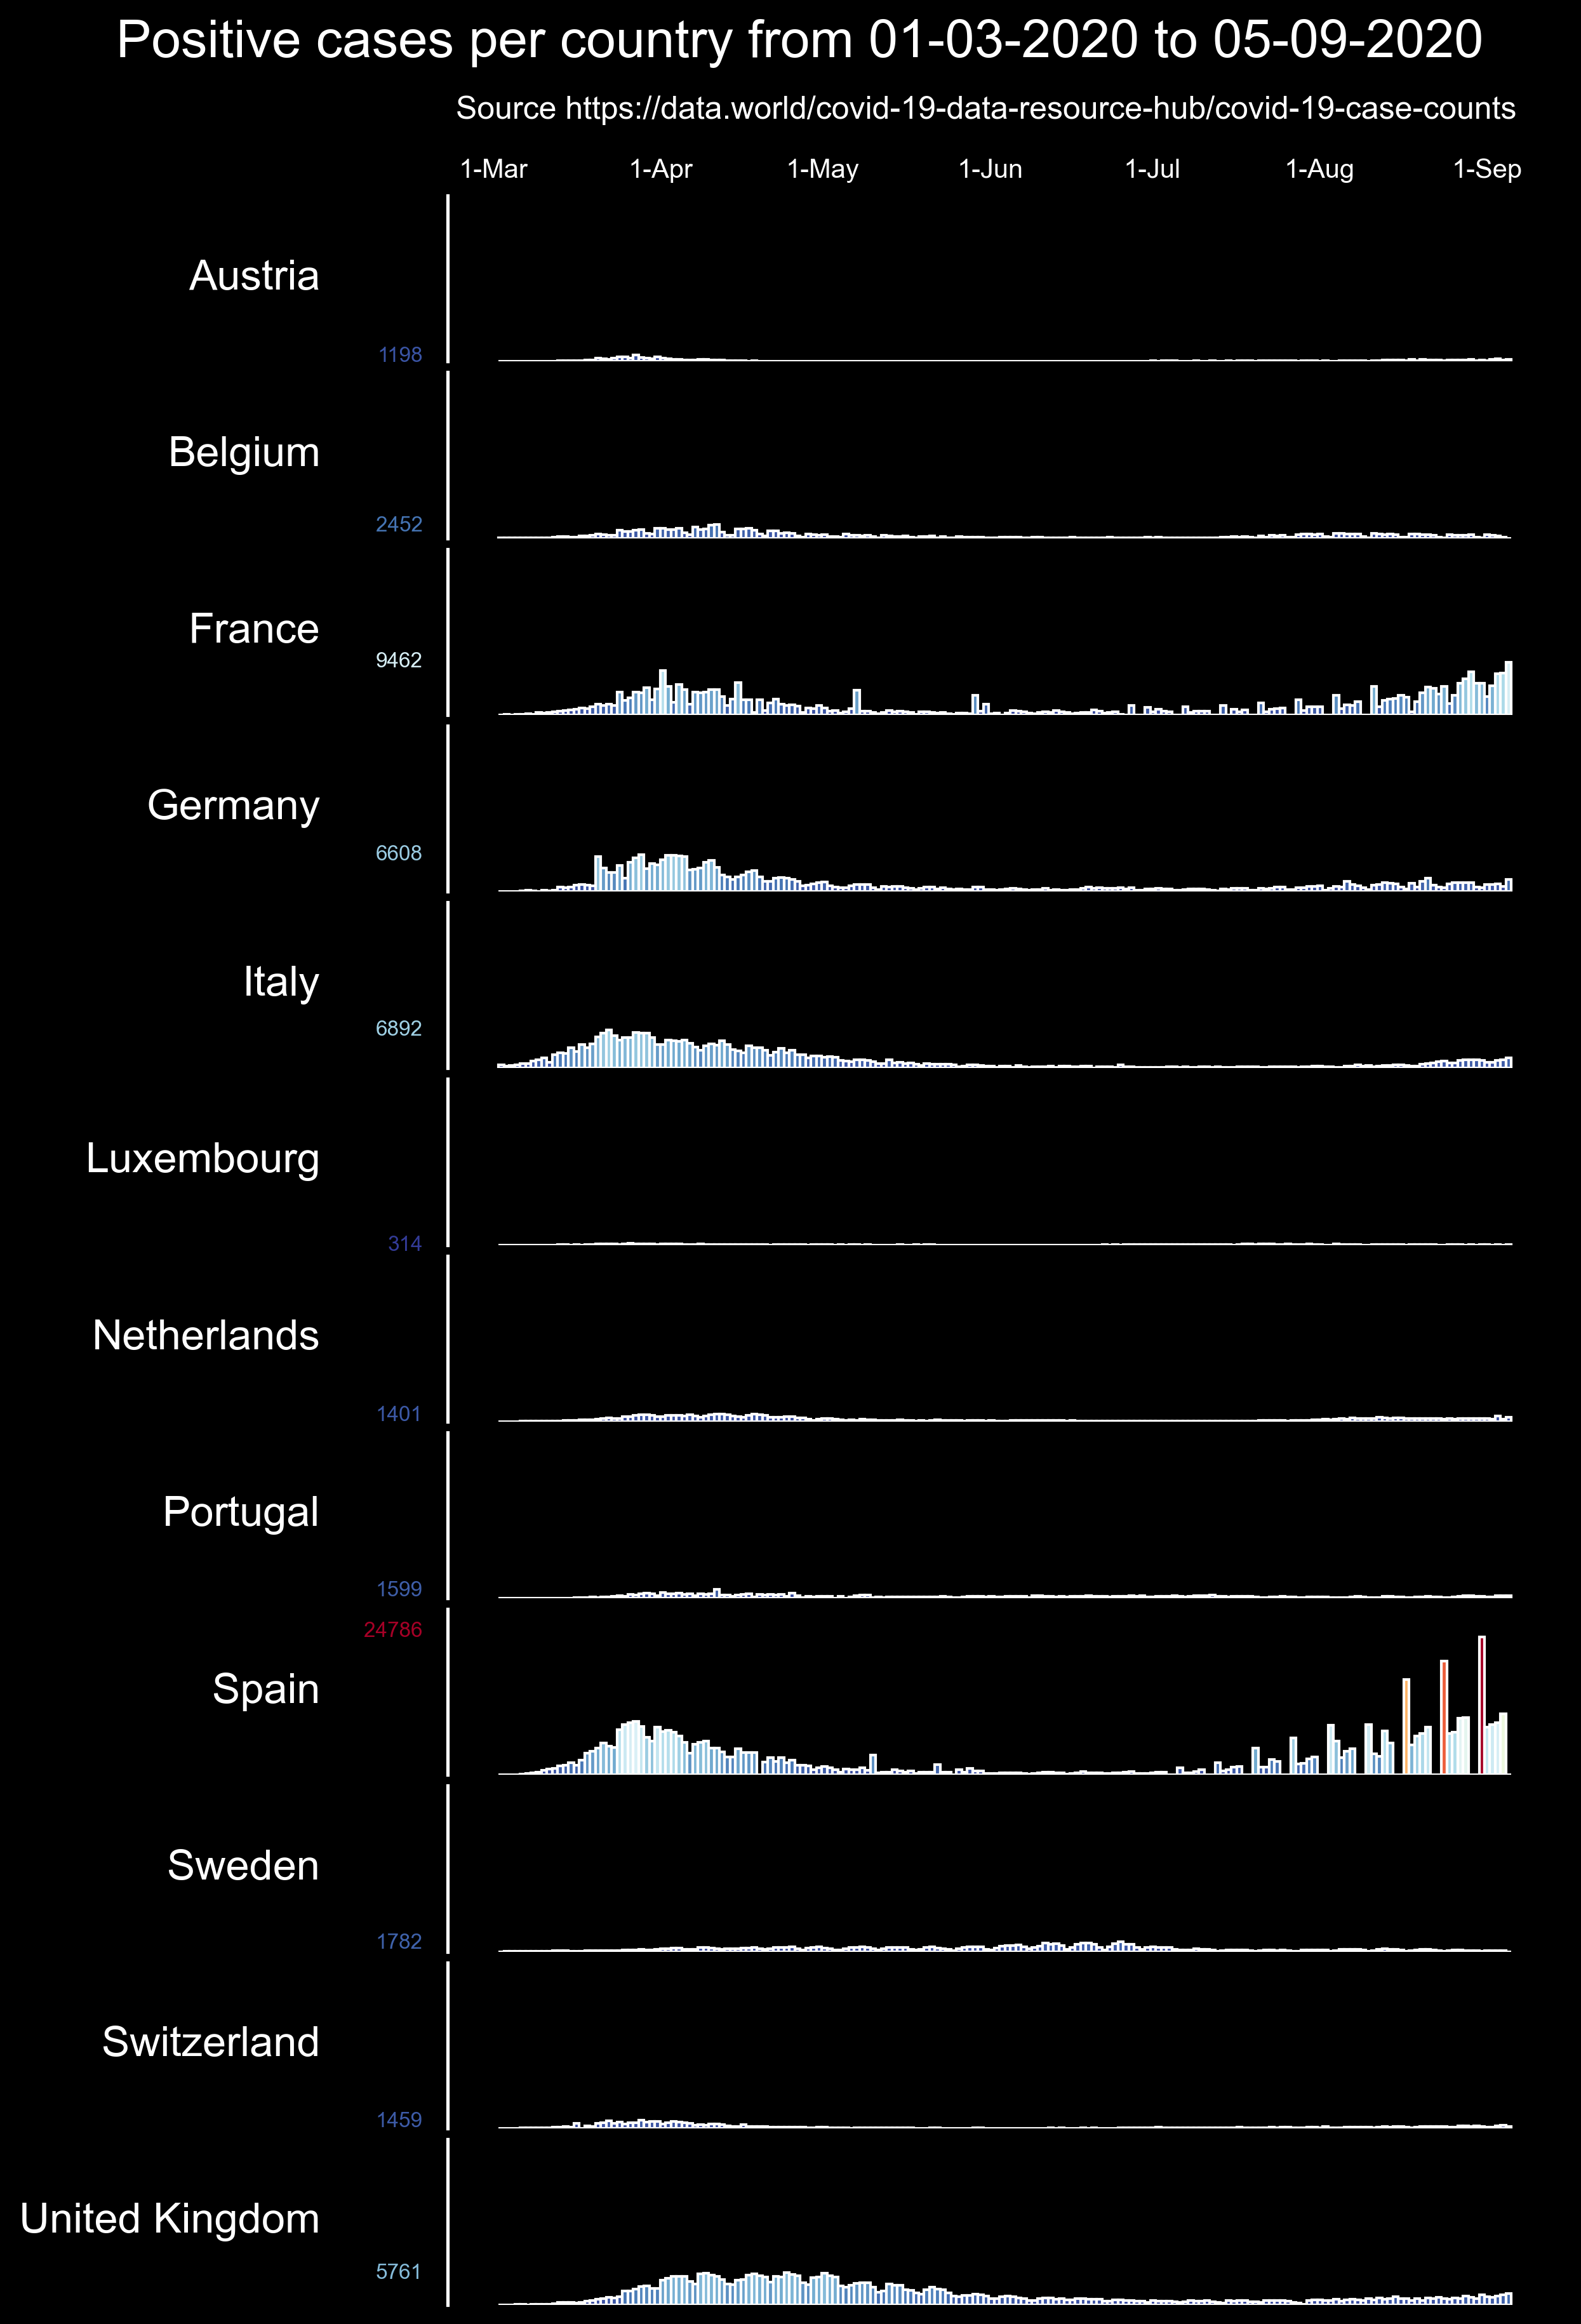

In [70]:
# Set canvas background color the same as axes
#mean_ratio=0.001
def format_x(value, tick_number):
        return  datetime.fromordinal(int(value)).strftime('%d-%b')


plt.rc('figure', facecolor='black')
plt.style.use('dark_background')
plt.ion()

# set constrianed_layout as True to avoid axes overlap
#fig = plt.figure(figsize=(10,20 ), dpi=300, constrained_layout=True)
fig = plt.figure(figsize=(8,12),dpi=300)
desde_fecha=datetime(year=2020,month=3,day=1)
hasta_fecha=resultados['Spain'].index[-1]
titulo='''Positive cases per country from {} to {}'''
fuente = '''Source https://data.world/covid-19-data-resource-hub/covid-19-case-counts'''
fig.suptitle(titulo.format(desde_fecha.strftime('%d-%m-%Y'),hasta_fecha.strftime('%d-%m-%Y'))        
           ,fontsize=20,x=.5,y=1,ha='center')
#fig.text(1.3, 12.8, fuente, horizontalalignment='right',
#         verticalalignment='center', transform=ax.transAxes)
fig.text(.97, .96, fuente, horizontalalignment='right',
         verticalalignment='center')

# Use GridSpec for customising layout
gs = fig.add_gridspec(nrows=13, ncols=8)

ax=fig.add_subplot(gs[0,1:9])
ax.bar(resultados['Spain'][resultados['Spain'].index > desde_fecha].index,0,color='xkcd:black',edgecolor='black',width=0.5,align='edge')
ax.set_facecolor('xkcd:black')
ax.spines['bottom'].set_visible(False)  
ax.spines['right'].set_visible(False)  
ax.spines['left'].set_visible(False)  
ax.spines['top'].set_visible(False)

ax.grid(False,which='both')
#ax.tick_params(axis='x',direction='out',labelrotation=90)
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_x))

ax.axes.get_yaxis().set_visible(False)
#ax.axes.get_xaxis().set_visible(False)
#ax.get_xaxis().set_ticks(resultados['M'][resultados['M'].index >= desde_fecha].index[::20])
ax.tick_params(axis='x',size=0,labelsize=10,pad=-10)
#ax.get_yaxis().set_ticks([])
#ax.xaxis.set_ticks_position(position='top')

majorFmt = mdates.DateFormatter('%-d-%b')
ax.xaxis.set_major_locator(mdates.MonthLocator([1,2,3,4,5,6,7,8,9,10,11,12]))
ax.xaxis.set_major_formatter(majorFmt)
#ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_y))


ratio_max=0
average_com={}
color_average_com={}
max_average=0
for i, com in enumerate(paises_interes):
    df_data=resultados[com][resultados[com].index >= desde_fecha]
    average_com[com]=df_data['CONFIRMED_INC'].mean()
    if average_com[com] > max_average:
        max_average=average_com[com]
    if df_data['CONFIRMED_INC'].replace(np.inf,np.nan).max() > ratio_max:
        ratio_max=df_data['CONFIRMED_INC'].max()
for i, com in enumerate(paises_interes):
    average_com[com]/=max_average
    color_average_com[com]=cm.RdYlGn_r(average_com[com])


for i, com in enumerate(paises_interes):
    #nombre provincias
    ax1 = fig.add_subplot(gs[i+1,0])
    ax1.set_facecolor('xkcd:black')
    ax1.annotate('{}'.format(com), (0.5, 0.5), size=16,xycoords='axes fraction', va='center', ha='right')
    ax1.spines['bottom'].set_visible(False)  
    ax1.spines['right'].set_visible(False)  
    ax1.spines['left'].set_visible(False)  
    ax1.spines['top'].set_visible(False)
    ax1.get_xaxis().set_ticks([])
    ax1.get_yaxis().set_ticks([])
    #ax = fig.add_subplot(19,1,i+1, ylim=(-.0001, 0.0001))
    ax = fig.add_subplot(gs[i+1, 1:9])
    
    ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    
    df_data=resultados[com][resultados[com].index > desde_fecha]
    mean_ratio=df_data['CONFIRMED'].mean()
    # color scheme
    # colors = cm.RdYlBu_r(resultados[com]['Fallecidos_por_hab'] / resultados[com]['Fallecidos_por_hab'].max())
    # ax.bar(resultados[com].index, df_data['Fallecidos_por_hab'] - mean_ratio, label='_1',color=colors,
    #       width=0.7, align="edge")
    
    #colors = cm.RdYlBu_r(df_data['Casos_habitantes'] / df_data['Casos_habitantes'].replace(np.inf,np.nan).max())
    colors = cm.RdYlBu_r(df_data['CONFIRMED_INC'] / ratio_max)
    
    ax.bar(df_data.index, df_data['CONFIRMED_INC'], label='_1',color=colors,
           width=1, align="edge")
    
    
    #Calculemos el color de valor maximo, para que indique el rango del valor
    color_max = colors[np.argmax(df_data['CONFIRMED_INC'])]
    start, end = ax.get_ylim()
    ax.get_yaxis().set_ticks([int(end)])
    ax.set_ylim([0,ratio_max*1.2])
    #ax.yaxis.label.set_color(color_max)
    ax.tick_params(axis='y',colors=color_max,labelsize=8)

    
    # customise axes
    ax.spines['bottom'].set_visible(False)  
    ax.spines['right'].set_visible(False)  
    #ax.spines['left'].set_visible(False)  
    ax.spines['top'].set_visible(False)
    ax.grid(False,which='both')
    ax.get_xaxis().set_ticks([])
    


    #ax.set_ylabel(comunidades[com][0], rotation=0, color='#e3e3e3', fontsize=10, fontweight='bold')
    
#plt.tight_layout()
plt.tight_layout(pad=0,w_pad=None,)
path='graficos/'
pref='temporal_por_paises_hasta'
nombre_fichero=path+pref+'.png'
fig.savefig(nombre_fichero)
plt.show()

Este notebook está disponible en mi [github](https://github.com/mharias/covid/blob/master/stats_cvid_paises.ipynb). Muchas gracias por el tiempo dedicado a leerlo, y espero que pueda aportar algo de información.

Detrás de cada número de este notebook  hay un drama personal y familiar, trato de no olvidarlo nunca..

In [71]:
ratio_max.round()

23572

In [72]:
fecha_inicio=datetime(year=2020,month=3,day=1)

In [73]:
datos_spain=resultados['Spain'][resultados['Spain']['CONFIRMED']>0]

In [74]:
datos_spain

,DEATHS,DEATHS_INC,CONFIRMED,CONFIRMED_INC,D2C,Ratio_Confirmed,inc
REPORT_DATE,,,,,,,
2020-02-01,0,0,1,1,0.000000,1.000000,inf
2020-02-02,0,0,1,0,0.000000,0.000000,-1.000000
2020-02-03,0,0,1,0,0.000000,0.000000,NaN
2020-02-04,0,0,1,0,0.000000,0.000000,NaN
2020-02-05,0,0,1,0,0.000000,0.000000,NaN
2020-02-06,0,0,1,0,0.000000,0.000000,NaN
2020-02-07,0,0,1,0,0.000000,0.000000,NaN
2020-02-08,0,0,1,0,0.000000,0.000000,NaN
2020-02-09,0,0,1,0,0.000000,0.000000,NaN


In [75]:
datos_spain['Confirmed_average_7'] = datos_spain.iloc[:,3].rolling(window=7).mean()

<ipython-input-75-4c837ece0e60>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_spain['Confirmed_average_7'] = datos_spain.iloc[:,3].rolling(window=7).mean()


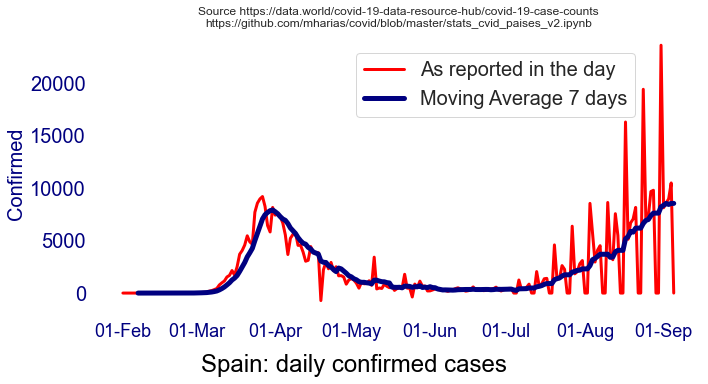

In [76]:
#plt.rc('figure', facecolor='white')
#plt.style.use('seaborn-whitegrid')
#plt.ion()
sns.set_style("whitegrid")
#sns.set_palette(sns.color_palette("vlag",7))

f = plt.figure(figsize=(10,5))
#plt.rcParams['figure.figsize'] = 10, 5
f.subplots_adjust(hspace=.5, wspace=.5)
f.suptitle('Spain: daily confirmed cases',fontsize=20,y=0,color='black',size=24)
ax1 = f.add_subplot(111)
ax1.spines['bottom'].set_visible(False)  
ax1.spines['right'].set_visible(False)  
ax1.spines['left'].set_visible(False)  
ax1.spines['top'].set_visible(False)
t=datos_spain.index
data1=datos_spain['CONFIRMED_INC']
data2=datos_spain['Confirmed_average_7']
ax1.set_title('Source https://data.world/covid-19-data-resource-hub/covid-19-case-counts\n'+\
              'https://github.com/mharias/covid/blob/master/stats_cvid_paises_v2.ipynb',size=12)
sns.lineplot(t, data1, ax=ax1, color='red',label='As reported in the day',linewidth=3)
sns.lineplot(t, data2, ax=ax1,color='navy',label='Moving Average 7 days',linewidth=5)

ax1.tick_params(axis='y', labelcolor='navy',labelsize=20)
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
#ax1.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.set_ylabel('Confirmed', size=20,color='navy')

majorFmt = mdates.DateFormatter('%d-%b')  
ax1.xaxis.set_major_formatter(majorFmt)
ax1.tick_params(axis='x', labelcolor='navy',labelsize=18)
ax1.set_xlabel('')

ax1.legend(loc=(.43,.7),fontsize=20)
ax1.grid(None)
f.tight_layout()
plt.show()
path='graficos/'
pref='confirmed_moving_average'
nombre_fichero=path+pref+'.png'
f.savefig(nombre_fichero,bbox_inches='tight',pad_inches=0.1)

/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


<Figure size 432x288 with 0 Axes>

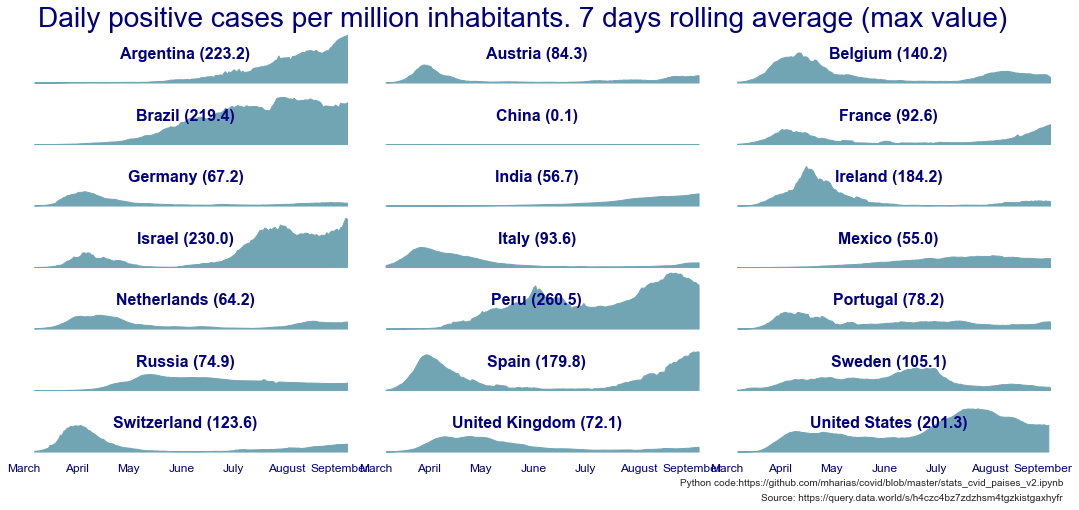

In [159]:
sns.set(style="white",rc={"axes.facecolor": (0, 0, 0, 0)})


# Preparamos los datos
datos=df2.reset_index()[df2.reset_index()['COUNTRY_SHORT_NAME'].isin(paises_interes)]
#datos['casos_millon']=datos.apply(lambda x: x['num_casos']/provincias[x['provincia_iso']][1]*10,axis=1)
datos = datos[datos['REPORT_DATE']>=datetime(year=2020,month=3,day=1)]
datos['Confirmed_millon']=datos.apply(lambda x: x['CONFIRMED_INC']/poblacion[x['COUNTRY_SHORT_NAME']]*1000,axis=1)
ordenada=sorted(paises_interes)
for i in datos['COUNTRY_SHORT_NAME'].unique():
    serie=datos.loc[datos['COUNTRY_SHORT_NAME']==i]['Confirmed_millon'].rolling(window=7).mean()
    datos.loc[datos['COUNTRY_SHORT_NAME']==i,'Confirmed_millon_average7']=serie

github_url = 'https://github.com/mharias/covid/blob/master/stats_cvid_paises_v2.ipynb'
    
    #datos['Confirmed_millon_average7']=datos['Confirmed_millon'].rolling(window=30).mean()
#datos['Confirmed_millon_average7']=datos.iloc[:,5].rolling(window=7).mean()

# Creamos la figura desde Matplotlib
plt.figure()

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(52, rot=-.25, light=.7)
g = sns.FacetGrid(datos,col='COUNTRY_SHORT_NAME', hue='COUNTRY_SHORT_NAME',col_wrap=3,col_order=ordenada,
                  aspect=5, height=1, palette=pal)
# Título
g.fig.suptitle('Daily positive cases per million inhabitants. 7 days rolling average (max value)',fontsize=28,color='navy')

g.fig.text(1, 0,'Source: {}'.format(path_datos), fontsize=10,horizontalalignment='right') #add text
g.fig.text(1,0.03,'Python code:{}'.format(github_url),
           fontsize=10,horizontalalignment='right')

# Draw the densities in a few steps
g.map(plt.fill_between, 'REPORT_DATE','Confirmed_millon_average7',color=pal[10])
#g.map(plt.axhline, y=0, lw=1, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    valor_max = datos[datos['COUNTRY_SHORT_NAME']==label]['Confirmed_millon_average7'].max()
    ax.text(0.5, .5, '{} ({:0.1f})'.format(label,valor_max), fontweight="bold", color='navy',
            ha="center", va="center", size=16,transform=ax.transAxes)


g.map(label,'COUNTRY_SHORT_NAME')


# Establecemos la distancia entre gráficos verticalmente para que no haya solapes
g.fig.subplots_adjust(hspace=0)

# Quitamos los títulos, título del eje x, y todos los ticks de y
g.set_titles("")
g.set(yticks=[])
g.set(xlabel='')

# Formateamos el gráfico: numero de xticks, formato de la etiqueta, colores...
majorFmt = DateFormatter('%B')
for ax in g.axes:
    ax.xaxis.set_major_formatter(majorFmt)
    ax.xaxis.set_tick_params(labelsize=12,labelcolor='navy')
    ax.xaxis.set_major_locator(DayLocator([1]))
    ax.set_xlim(datos['REPORT_DATE'].unique()[0],datos['REPORT_DATE'].unique()[-1])

# quitamos los ejes para dar más claridad a cada gráfico
g.despine(bottom=True, left=True)


#g.tight_layout(w_pad=0,h_pad=0,pad=5)
g.savefig('graficos/pcr+_countries.png',dpi=100)  

plt.show()


https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html

<ipython-input-27-a98f4d6eeef3>:179: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(w_pad=0,h_pad=3,pad=1)


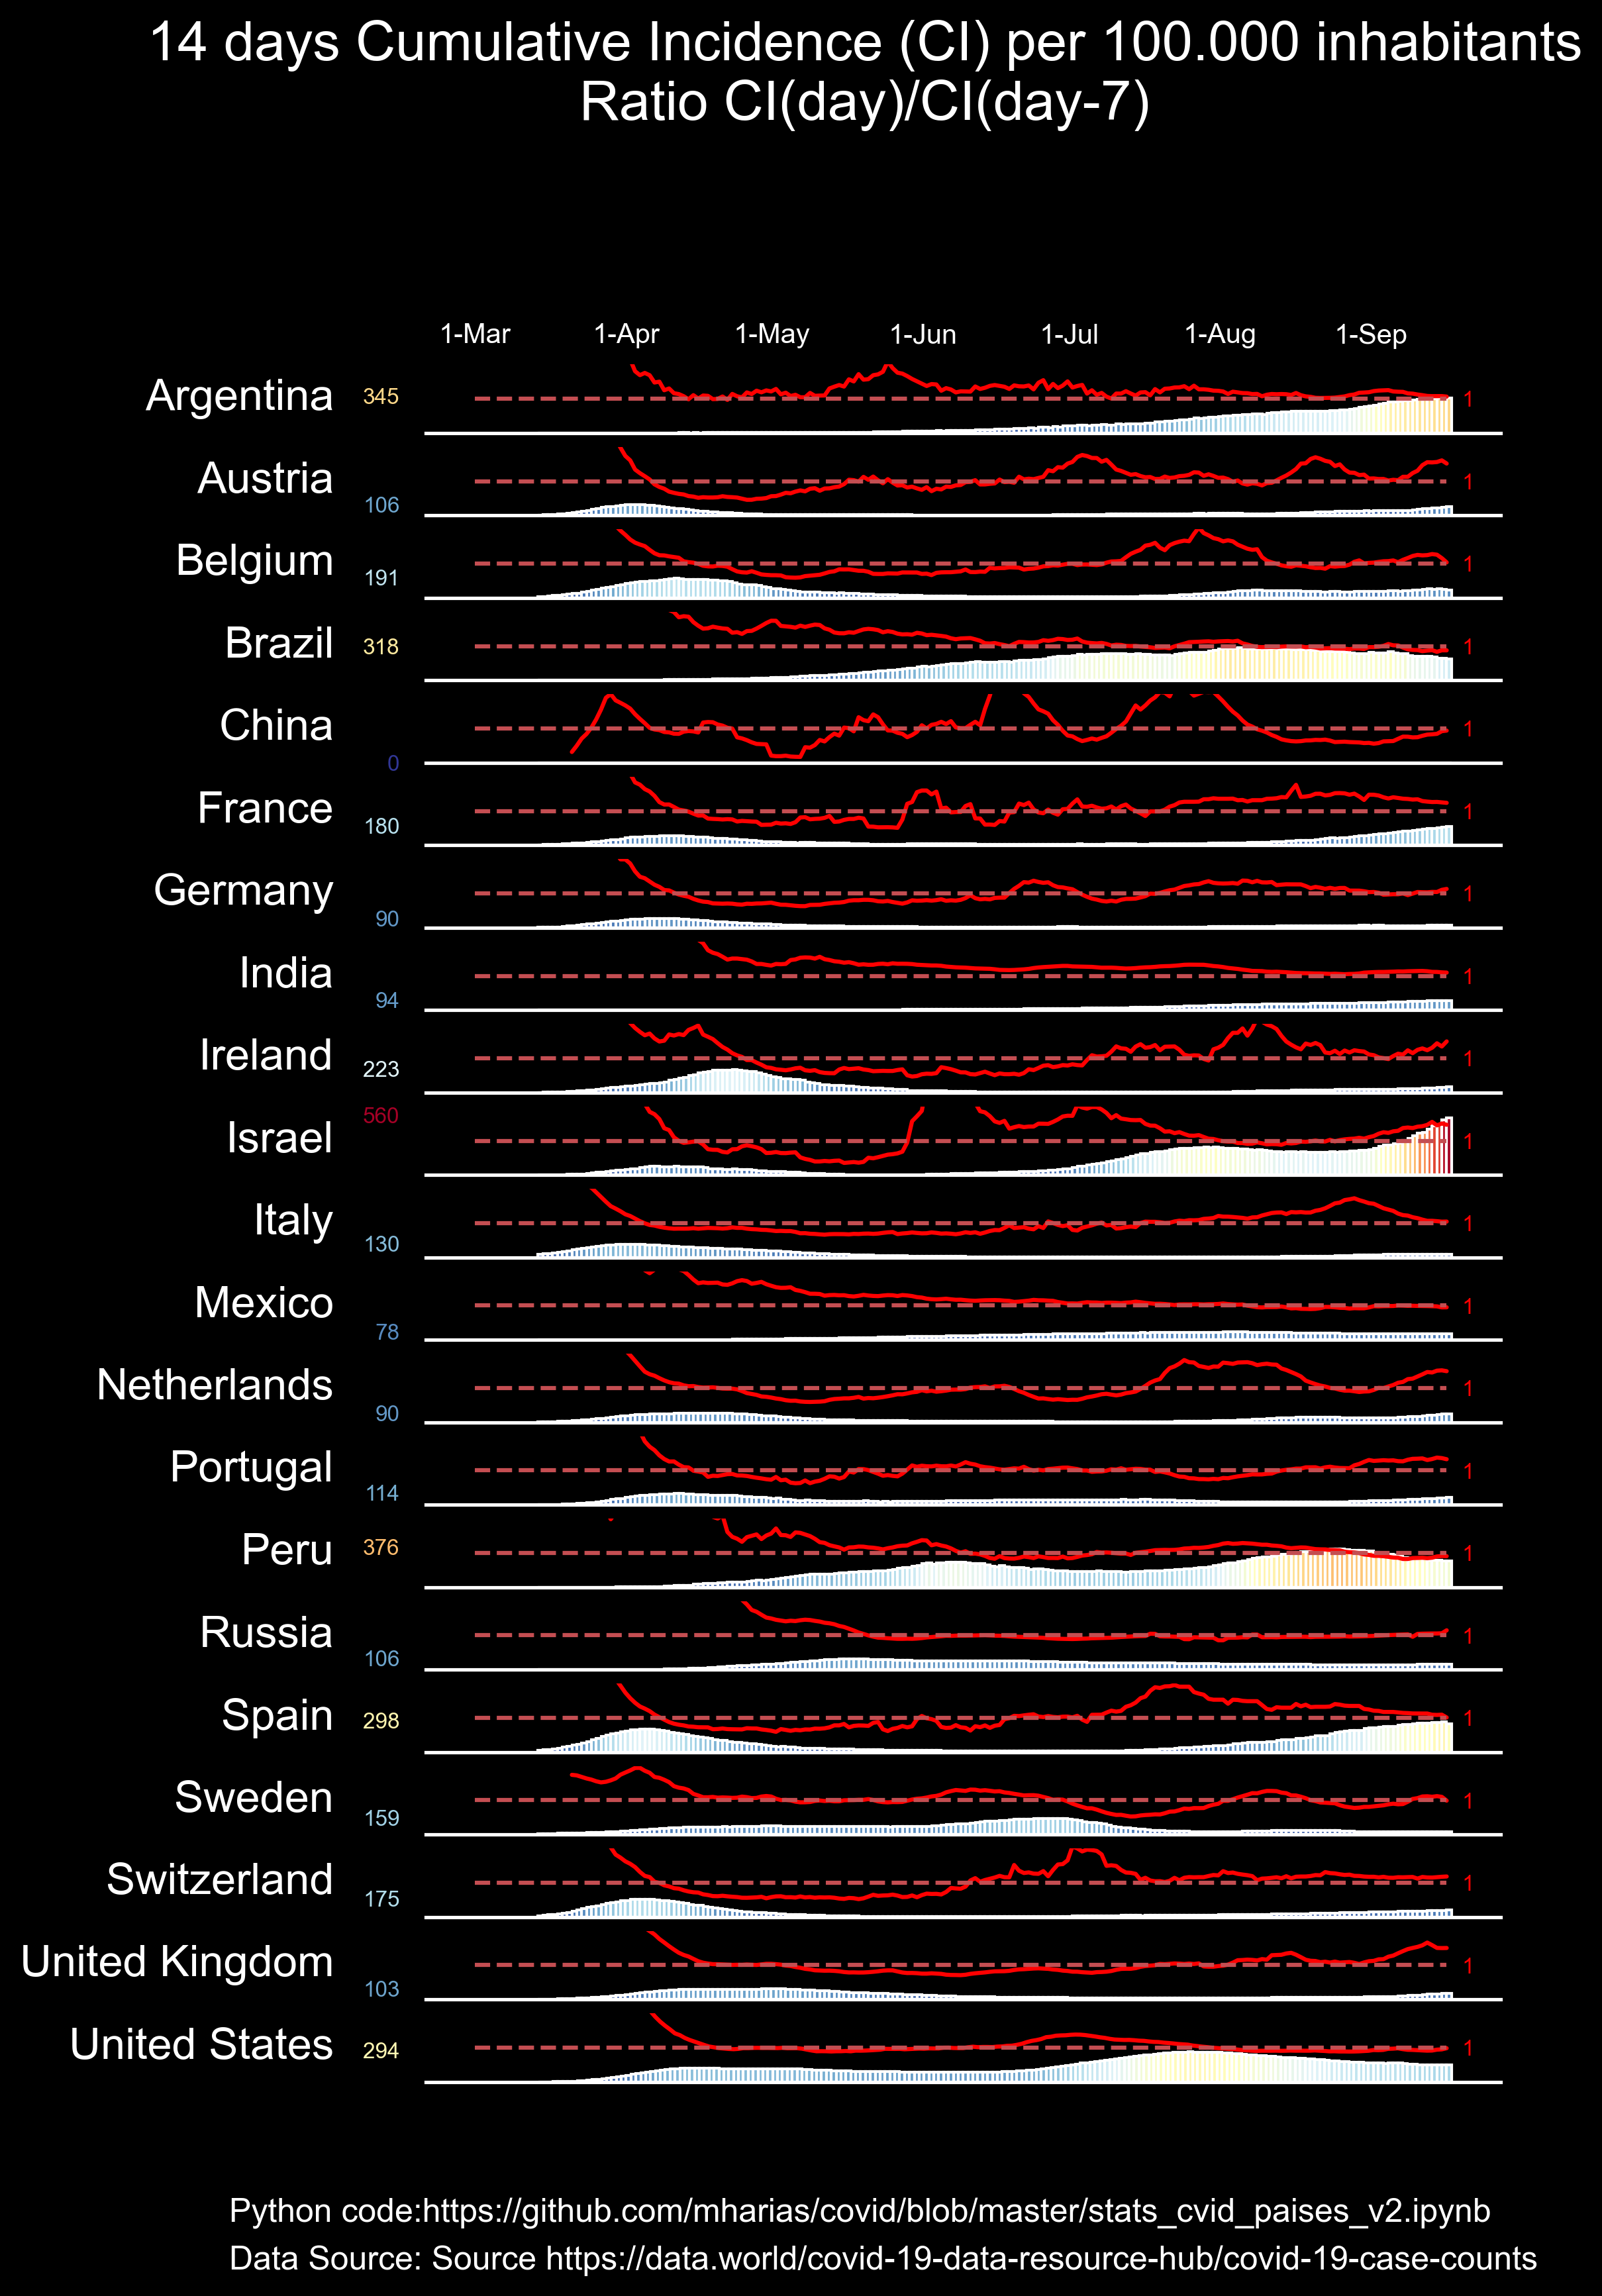

In [27]:
sns.set(style="white",rc={"axes.facecolor": (0, 0, 0, 0)})


# Preparamos los datos
IA='incidencia_acumulada_14'
clave_ratio='ratio_tasas'
nuevos_casos= 'CONFIRMED_INC'
desde_fecha=datetime(year=2020,month=3,day=1)
hasta_fecha=resultados['Spain'].index[-1]

datos=df2.reset_index()[df2.reset_index()['COUNTRY_SHORT_NAME'].isin(paises_interes)]
    #datos['casos_millon']=datos.apply(lambda x: x['num_casos']/provincias[x['provincia_iso']][1]*10,axis=1)

datos = datos[datos['REPORT_DATE']>=desde_fecha]
datos['Confirmed_millon']=datos.apply(lambda x: x['CONFIRMED_INC']/poblacion[x['COUNTRY_SHORT_NAME']]*1000,axis=1)
ordenada=sorted(paises_interes)

for i in paises_interes:
    serie=datos.loc[datos['COUNTRY_SHORT_NAME']==i]['Confirmed_millon'].rolling(window=7).mean()
    datos.loc[datos['COUNTRY_SHORT_NAME']==i,'Confirmed_millon_average7']=serie

for pais in paises_interes:
    
    datos.loc[datos[clave_pais]==pais,IA]=\
    datos.loc[datos[clave_pais]==pais,nuevos_casos].rolling(window=14).sum()\
    /poblacion[pais]*100

    datos.loc[datos[clave_pais]==pais,clave_ratio] = \
    datos.loc[datos[clave_pais]==pais][IA].pct_change(periods=7).add(1)    
    
    datos.loc[datos[clave_pais]==i,'Confirmed_millon_average7'] = \
    datos.loc[datos[clave_pais]==i]['Confirmed_millon'].rolling(window=7).mean()
    
    
github_url = 'https://github.com/mharias/covid/blob/master/stats_cvid_paises_v2.ipynb'
titulo='''14 days Cumulative Incidence (CI) per 100.000 inhabitants\nRatio CI(day)/CI(day-7)'''
fuente = '''Source https://data.world/covid-19-data-resource-hub/covid-19-case-counts'''   
    #datos['Confirmed_millon_average7']=datos['Confirmed_millon'].rolling(window=30).mean()
#datos['Confirmed_millon_average7']=datos.iloc[:,5].rolling(window=7).mean()

# Set canvas background color the same as axes
#mean_ratio=0.001
def format_x(value, tick_number):
        return  datetime.fromordinal(int(value)).strftime('%d-%b')


plt.rc('figure', facecolor='black')
plt.style.use('dark_background')
plt.ion()

# set constrianed_layout as True to avoid axes overlap
#fig = plt.figure(figsize=(10,20 ), dpi=300, constrained_layout=True)
fig = plt.figure(figsize=(8,12),dpi=300)


fig.suptitle(titulo.format(desde_fecha.strftime('%d-%m-%Y'),hasta_fecha.strftime('%d-%m-%Y'))        
           ,fontsize=20,x=.5,y=.99,ha='center')
#fig.text(1.3, 12.8, fuente, horizontalalignment='right',
#         verticalalignment='center', transform=ax.transAxes)
fig.text(.1, 0.05, 'Data Source: {}'.format(fuente), horizontalalignment='left',
         verticalalignment='center')
fig.text(.1, 0.07, 'Python code:{}'.format(github_url), horizontalalignment='left',
         verticalalignment='center')

# Use GridSpec for customising layout
gs = fig.add_gridspec(nrows=22, ncols=8)

ax=fig.add_subplot(gs[0,1:9])
ax.bar(datos.loc[datos[clave_pais] == 'Spain']['REPORT_DATE'],0,
       color='xkcd:black',edgecolor='black',width=0.5,align='edge')
ax.set_facecolor('xkcd:black')
ax.spines['bottom'].set_visible(False)  
ax.spines['right'].set_visible(False)  
ax.spines['left'].set_visible(False)  
ax.spines['top'].set_visible(False)

ax.grid(False,which='both')
#ax.tick_params(axis='x',direction='out',labelrotation=90)
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_x))

ax.axes.get_yaxis().set_visible(False)
#ax.axes.get_xaxis().set_visible(False)
#ax.get_xaxis().set_ticks(resultados['M'][resultados['M'].index >= desde_fecha].index[::20])
ax.tick_params(axis='x',size=0,labelsize=10,pad=-10)
#ax.get_yaxis().set_ticks([])
#ax.xaxis.set_ticks_position(position='top')

majorFmt = mdates.DateFormatter('%-d-%b')
ax.xaxis.set_major_locator(mdates.MonthLocator([1,2,3,4,5,6,7,8,9,10,11,12]))
ax.xaxis.set_major_formatter(majorFmt)
#ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_y))


ratio_max=0
average_pais={}
color_average_pais={}
max_average=0
for i, pais in enumerate(paises_interes):
    average_pais[pais]=datos.loc[datos[clave_pais] == pais][IA].mean()
    if average_pais[pais] > max_average:
        max_average=average_pais[pais]
    if datos.loc[datos[clave_pais] == pais][IA].max() > ratio_max:
        ratio_max=datos.loc[datos[clave_pais] == pais][IA].max()

for i, pais in enumerate(paises_interes):
    average_pais[pais]/=max_average
    color_average_pais[pais]=cm.RdYlGn_r(average_pais[pais])


for i, pais in enumerate(paises_interes):
    #nombre provincias
    ax1 = fig.add_subplot(gs[i+1,0])
    ax1.set_facecolor('xkcd:black')
    ax1.annotate('{}'.format(pais), (0.5, 0.5), size=16,xycoords='axes fraction', va='center', ha='right')
    ax1.spines['bottom'].set_visible(False)  
    ax1.spines['right'].set_visible(False)  
    ax1.spines['left'].set_visible(False)  
    ax1.spines['top'].set_visible(False)
    ax1.get_xaxis().set_ticks([])
    ax1.get_yaxis().set_ticks([])
    #ax = fig.add_subplot(19,1,i+1, ylim=(-.0001, 0.0001))
    ax2 = fig.add_subplot(gs[i+1, 1:9])
    
    ax2.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    
    df_data = datos.loc[datos[clave_pais] == pais]
    mean_ratio=df_data[IA].mean()
    # color scheme
    # colors = cm.RdYlBu_r(resultados[com]['Fallecidos_por_hab'] / resultados[com]['Fallecidos_por_hab'].max())
    # ax.bar(resultados[com].index, df_data['Fallecidos_por_hab'] - mean_ratio, label='_1',color=colors,
    #       width=0.7, align="edge")
    
    #colors = cm.RdYlBu_r(df_data['Casos_habitantes'] / df_data['Casos_habitantes'].replace(np.inf,np.nan).max())
    colors = cm.RdYlBu_r(df_data[IA] / ratio_max)
    
    ax2.bar(df_data['REPORT_DATE'], df_data[IA], label='_1',color=colors,
           width=1, align="edge")
    
    
    #Calculemos el color de valor maximo, para que indique el rango del valor
    color_max = colors[np.argmax(df_data[IA])]
    start, end = ax2.get_ylim()
    ax2.get_yaxis().set_ticks([int(end)])
    ax2.set_ylim([0,ratio_max*1.2])
    #ax.yaxis.label.set_color(color_max)
    ax2.tick_params(axis='y',colors=color_max,labelsize=8,width=0)

    
    # customise axes
    ax2.spines['bottom'].set_visible(False)  
    ax2.spines['right'].set_visible(False)  
    ax2.spines['left'].set_visible(False)  
    ax2.spines['top'].set_visible(False)
    ax2.grid(False,which='both')
    ax2.get_xaxis().set_ticks([])
        
    ax3 = ax2.twinx()
    ax3.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    ax3.plot(df_data['REPORT_DATE'], df_data[clave_ratio], label='_1',color='red')
    
    #ax3.yaxis.set_tick_params(labelsize=16,labelcolor=color_avg,width=0)
    ax3.set_ylim([0,2])
    ax3.tick_params(axis='y',colors='red',labelsize=8,width=0,pad=-20)
    ax3.set_yticks([1])
    #ax3.spines['bottom'].set_visible(False)  
    ax3.spines['right'].set_visible(False)  
    ax3.spines['left'].set_visible(False)  
    ax3.spines['top'].set_visible(False)
    ax3.grid(False,which='both')
    ax3.get_xaxis().set_ticks([])
    
    horiz_line_data = np.array([1 for i in range(len(df_data['REPORT_DATE']))])
    ax3.plot(df_data['REPORT_DATE'], horiz_line_data, 'r--') 
    #ax.set_ylabel(comunidades[com][0], rotation=0, color='#e3e3e3', fontsize=10, fontweight='bold')
    
#plt.tight_layout()
fig.tight_layout(w_pad=0,h_pad=3,pad=1)
path='graficos/'
pref='temporal_por_paises_hasta'
nombre_fichero=path+pref+'.png'
fig.savefig(nombre_fichero)
plt.show()